In [1]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
from PIL import Image

In [102]:
torch.rand(1)[0].item()

0.15995573997497559

In [103]:
def IoU(box1, box2):
    return torch.rand(1)[0].item()

In [58]:
class VOCDataset(Dataset):
    def __init__(self, devkit_path, 
                 subsets = [('VOC2007', 'trainval'), ('VOC2012', 'trainval') ], 
                 anchors = [], scales = [13], 
                 transforms = None,
                 show = False,
                 dtype=None, device=None):
        super().__init__()
        self.devkit_path = devkit_path
        self.subsets = subsets
        self.anchors = anchors
        self.scales = scales
        self.transforms = transforms
        self.show = show
        self.dtype = dtype
        self.device = device

        self.all_labels = []
        for subset in self.subsets:
            subset_path = os.path.join(self.devkit_path, subset[0], 'ImageSets', 'Main', '{}.txt'.format(subset[1]))
            print(os.path.exists(subset_path), subset_path)
            with open(subset_path, 'r') as file:
                subset_labels = file.read().splitlines()
            self.all_labels.append(subset_labels)

        self.classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                        'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                        'tvmonitor']

    def __getitem__(self, idx):
        # get paths
        subset_idx = 0
        for subset_labels in self.all_labels:
            if idx < len(subset_labels):
                break
            else:
                subset_idx += 1
                idx -= len(subset_labels)

        if idx < 0 or subset_idx >= len(self.subsets):
            raise Exception("Index out of range.")

        print(subset_idx, idx)
        image_path = os.path.join(self.devkit_path, self.subsets[subset_idx][0], 'JPEGImages', '{}.jpg'.format(self.all_labels[subset_idx][idx]))
        annotation_path = os.path.join(self.devkit_path, self.subsets[subset_idx][0], 'Annotations', '{}.xml'.format(self.all_labels[subset_idx][idx]))

        print(os.path.exists(image_path), image_path)
        print(os.path.exists(annotation_path), annotation_path)

        # get PIL image
        PIL_img = Image.open(image_path)

        if self.show:
            return PIL_img

        # initialize tensors
        gt_out = [torch.empty(self.anchors*(5+len(self.classes)), scale, scale) for scale in self.scales]
        
        # parse annotations
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        img_w = int(root.find("./size/width").text)
        img_h = int(root.find("./size/height").text)
        img_d = int(root.find("./size/depth").text)

        for i, item in enumerate(root.findall('./object')):
            label = item.find("name").text
            bndbox = item.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
        
            obj_w = xmax - xmin
            obj_h = ymax - ymin

            obj_xc = xmax - obj_w / 2
            obj_yc = ymax - obj_h / 2

            for scale in self.scales:
                cell_w = img_w / scale
                cell_h = img_h / scale

                cell_x = obj_xc // cell_w
                cell_y = obj_yc // cell_h

                obj_xc = obj_xc - cell_x*cell_w
                obj_yc = obj_yc - cell_y*cell_h

                obj_w = obj_w / cell_w
                obj_h = obj_h / cell_h

                bndbox = torch.tensor([obj_xc, obj_yc, obj_w, obj_h])
                
                IoUs = [IoU(bndbox, anchor) for anchor in self.anchors]
                
    def __len__(self):
        summed_len = 0
        for _subset in self.all_labels:
            summed_len += len(_subset)
        return summed_len

In [63]:
train_set = VOCDataset(devkit_path = '../../datasets/VOCdevkit/', show=True)

True ../../datasets/VOCdevkit/VOC2007\ImageSets\Main\trainval.txt
True ../../datasets/VOCdevkit/VOC2012\ImageSets\Main\trainval.txt


In [64]:
len(train_set)

16551

0 5000
True ../../datasets/VOCdevkit/VOC2007\JPEGImages\009944.jpg
True ../../datasets/VOCdevkit/VOC2007\Annotations\009944.xml


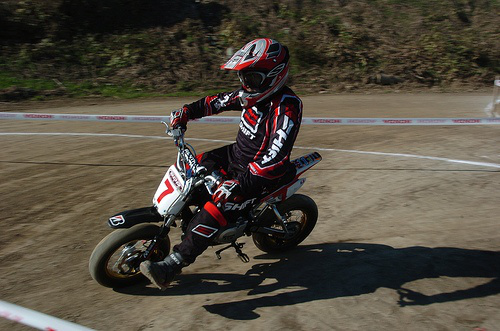

In [67]:
train_set[5000]

In [5]:
xmlfile = '../../datasets/VOCdevkit/VOC2007/Annotations/009944.xml'
tree = ET.parse(xmlfile)

In [6]:
tree

In [7]:
root = tree.getroot()

In [8]:
root

<Element 'annotation' at 0x000002958AB8D540>

In [55]:
img_w = int(root.find("./size/width").text)
img_h = int(root.find("./size/height").text)
img_d = int(root.find("./size/depth").text)

In [57]:
for i, item in enumerate(root.findall('./object')):
    label = item.find("name").text
    bndbox = item.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)

    obj_w = xmax - xmin
    obj_h = ymax - ymin

    x_c = xmax - obj_w / 2
    y_c = ymax - obj_h / 2

    obj_w /= img_w
    obj_h /= img_h

    x_c /= img_w
    y_c /= img_h

    print(label, x_c, y_c, obj_w, obj_h)

motorbike 0.416 0.620845921450151 0.484 0.5166163141993958
person 0.45 0.4954682779456193 0.32 0.7613293051359517


In [40]:
for child in root:
    print(child)

<Element 'folder' at 0x000002958AB8D680>
<Element 'filename' at 0x000002958AB8D630>
<Element 'source' at 0x000002958AB8D720>
<Element 'owner' at 0x000002958AB8D8B0>
<Element 'size' at 0x000002958AB8DC70>
<Element 'segmented' at 0x000002958AB8DD60>
<Element 'object' at 0x000002958AB8DD10>
<Element 'object' at 0x00000295EE89C180>


In [45]:
objs = root.findall("./object")

In [50]:
objs[0].findall("name")

[<Element 'name' at 0x000002958AB8DE00>]